# Scheduling: P | p - batch, incompatible | TWT
In diesem Notebook soll das obige Ablaufplanungsproblem mit einer Anwendung der VNS-Metaheuristik (Variable Neighborhood Search) gelöst werden. Das Problem ist eine Verallgemeinerung vom Problem 1 || TWT, welches NP-hart ist. Eine Metaheuristik kann folglich zur effizienten Lösung des Problems angewendet werden.

Zuerst generieren wir ein zufälliges Setup von parallen Maschinen, Produktfamilien mit eigenen Laufzeiten und Jobs.

In [12]:
import numpy as np
import pandas as pd
import random

MIN_JOBS = 50
MAX_JOBS = 200
MIN_BATCH_SIZE = 2
MAX_BATCH_SIZE= 10
MIN_FAMILIES = 5
MAX_FAMILIES = 25
MIN_PROCESSING_TIME = 2
MAX_PROCESSING_TIME = 50
MIN_WEIGHT = 1
MAX_WEIGHT = 10
MIN_DUE_DATE = 8
MAX_DUE_DATE = 200
MIN_MACHINES = 2
MAX_MACHINES = MIN_FAMILIES

BATCH_SIZE = random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE)
NO_OF_JOBS = random.randint(MIN_JOBS, MAX_JOBS)
NO_OF_FAMILIES = random.randint(MIN_FAMILIES, MAX_FAMILIES)
NO_OF_MACHINES = random.randint(MIN_MACHINES, MAX_MACHINES)

# generate a schedule consisting of random jobs
schedule = pd.DataFrame({
    "w": np.random.randint(MIN_WEIGHT, MAX_WEIGHT, size=NO_OF_JOBS),
    "d": np.random.randint(MIN_DUE_DATE, MAX_DUE_DATE, size=NO_OF_JOBS),
    "f": np.empty(NO_OF_JOBS, dtype='object'),
    "p_f": np.full(NO_OF_JOBS, np.nan),
    "atc_S": np.full(NO_OF_JOBS, np.nan),
    "m": np.empty(NO_OF_JOBS, dtype='object'),
    "S": np.full(NO_OF_JOBS, np.nan),
    "C": np.full(NO_OF_JOBS, np.nan),
    "b": np.empty(NO_OF_JOBS, dtype='object'),
    "batc_S": np.full(NO_OF_JOBS, np.nan),
})

# assign families to jobs, family ids are intentionally strings
p_f = {str(i): random.randint(MIN_PROCESSING_TIME, MAX_PROCESSING_TIME) for i in range(NO_OF_FAMILIES)}

for i, row in schedule.iterrows():
    f = random.choice(list(p_f.keys()))
    schedule.at[i, "f"] = f
    schedule.at[i, "p_f"] = p_f[f]
    
del p_f

# show jobs
schedule

,w,d,f,p_f,atc_S,m,S,C,b,batc_S
0,8,28,3,28.0,NaN,None,NaN,NaN,None,NaN
1,8,146,12,43.0,NaN,None,NaN,NaN,None,NaN
2,3,87,7,36.0,NaN,None,NaN,NaN,None,NaN
3,9,15,16,27.0,NaN,None,NaN,NaN,None,NaN
4,2,10,8,31.0,NaN,None,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...
177,4,26,9,23.0,NaN,None,NaN,NaN,None,NaN
178,8,139,14,11.0,NaN,None,NaN,NaN,None,NaN
179,9,15,0,46.0,NaN,None,NaN,NaN,None,NaN
180,1,28,4,38.0,NaN,None,NaN,NaN,None,NaN


In [13]:
schedule[["w", "d", "p_f"]].describe()

,w,d,p_f
count,182.000000,182.000000,182.000000
mean,5.032967,101.851648,30.214286
std,2.661161,56.077442,12.364770
min,1.000000,9.000000,6.000000
25%,3.000000,58.000000,24.000000
50%,5.000000,95.500000,28.000000
75%,7.000000,153.250000,42.000000
max,9.000000,199.000000,50.000000


TWT Funktion: $\sum_{j=1}^n w_j T_j = \sum_{j=1}^n w_j \max\{C_j - d_j; 0\}$

In [14]:
def calculate_twt(job: pd.DataFrame) -> int:
    return sum(job.w * np.maximum(job.C - job.d, 0))

ATC-Funktion:

In [15]:
from math import exp

def calculate_atc(job: pd.Series, p_avg: float, t: int, kappa: int) -> float:
    return (job.w / job.p_f) * exp(-(max(job.d - job.p_f - t, 0))/(kappa * p_avg))

## Eröffnungsheuristik: ATC-BATC-Heuristic

In [16]:
# total weighted tardiness of the best schedule
atc_batc_twt = None
    
for kappa in [0.5 * l for l in range(1, 11)]:
    #  copy of the schedule to be modified during the search for the best schedule
    temp_schedule = schedule.copy()
    # list of jobs that are not assigned to a machine
    non_assigned_jobs = temp_schedule.copy()
    # machine object with the time when the machine will be free
    machines = pd.Series(np.zeros(NO_OF_MACHINES), name="free_at")
    # time step
    t = 0
    # iterate until all jobs are assigned
    while(non_assigned_jobs.shape[0] > 0):
        # skip if no machine is free
        while len(machines[machines <= t]) > 0:
            # calculate and sort jobs by ATC
            p_avg = non_assigned_jobs.p_f.mean()
            non_assigned_jobs.atc_S = non_assigned_jobs.apply(lambda job: calculate_atc(job, p_avg, 0, kappa), axis=1)
            non_assigned_jobs.sort_values(by="atc_S", ascending=False, inplace=True)
            # get the top batch over all families containing the top min(BATCH_SIZE, NO_OF_JOBS remaining in family) jobs by atc
            batch, batc = None, None
            # iterate over remaining families
            for f in non_assigned_jobs.f.unique():
                # build batch from the remaining jobs of family f and calculate its Batch ATC
                f_remaining = non_assigned_jobs[non_assigned_jobs.f == f]
                f_batch = f_remaining.iloc[:min(BATCH_SIZE, f_remaining.shape[0])]
                f_batc = sum(f_batch.atc_S)
                # if the batch is better than the current best, update the best batch
                if batch is None or f_batc > batc:
                    batch, batc = f_batch.copy(), f_batc
            # break if no batch was found - this should only happen if all jobs are assigned
            if batch is None:
                break
            # assign the best batch to first free machine
            machine_idx = machines[machines <= t].idxmin()
            machines.iloc[machine_idx] = t + batch.p_f.iloc[0]
            # remove the assigned jobs from the non assigned jobs
            non_assigned_jobs.drop(batch.index, inplace=True)
            # overwrite the jobs list with the updated batch
            batch[["m", "S", "C", "b", "batc_S"]] = str(machine_idx), t, t + batch.p_f.iloc[0], f"S{int(t)}.F{batch.f.iloc[0]}.M{machine_idx}", batc
            temp_schedule.update(batch)
        # skip to the next time step when a machine is free
        t = machines.min()
    schedule = temp_schedule
    # update the best schedule if the current one is better
    temp_twt = calculate_twt(temp_schedule)
    print(f"Kappa: {kappa}, TWT: {temp_twt}")
    if atc_batc_twt is None or temp_twt < atc_batc_twt:
        atc_batc_twt = temp_twt
        schedule = temp_schedule

print("-" * 30)
print(f"Best TWT: {atc_batc_twt}")

Kappa: 0.5, TWT: 121624.0
Kappa: 1.0, TWT: 107455.0
Kappa: 1.5, TWT: 93464.0
Kappa: 2.0, TWT: 85093.0
Kappa: 2.5, TWT: 78656.0
Kappa: 3.0, TWT: 75300.0
Kappa: 3.5, TWT: 72802.0
Kappa: 4.0, TWT: 71338.0
Kappa: 4.5, TWT: 71567.0
Kappa: 5.0, TWT: 71343.0
------------------------------
Best TWT: 71338.0


In [17]:
schedule.sort_values(by=["S", "C", "b"], inplace=True)
schedule.set_index("b", inplace=True)
schedule

,w,d,f,p_f,atc_S,m,S,C,batc_S
b,,,,,,,,,
S0.F15.M0,9.0,14.0,15,6.0,1.422634,0,0.0,6.0,3.103247
S0.F15.M0,7.0,115.0,15,6.0,0.567019,0,0.0,6.0,3.103247
S0.F15.M0,9.0,51.0,15,6.0,1.113594,0,0.0,6.0,3.103247
S0.F15.M2,6.0,111.0,15,6.0,0.508178,2,0.0,6.0,1.615932
S0.F15.M2,7.0,118.0,15,6.0,0.566714,2,0.0,6.0,1.615932
...,...,...,...,...,...,...,...,...,...
S450.F7.M3,1.0,90.0,7,36.0,0.020612,3,450.0,486.0,0.020612
S473.F16.M2,1.0,136.0,16,27.0,0.020298,2,473.0,500.0,0.020298
S474.F1.M0,2.0,184.0,1,47.0,0.021203,0,474.0,521.0,0.021203


<Figure size 2560x1600 with 0 Axes>

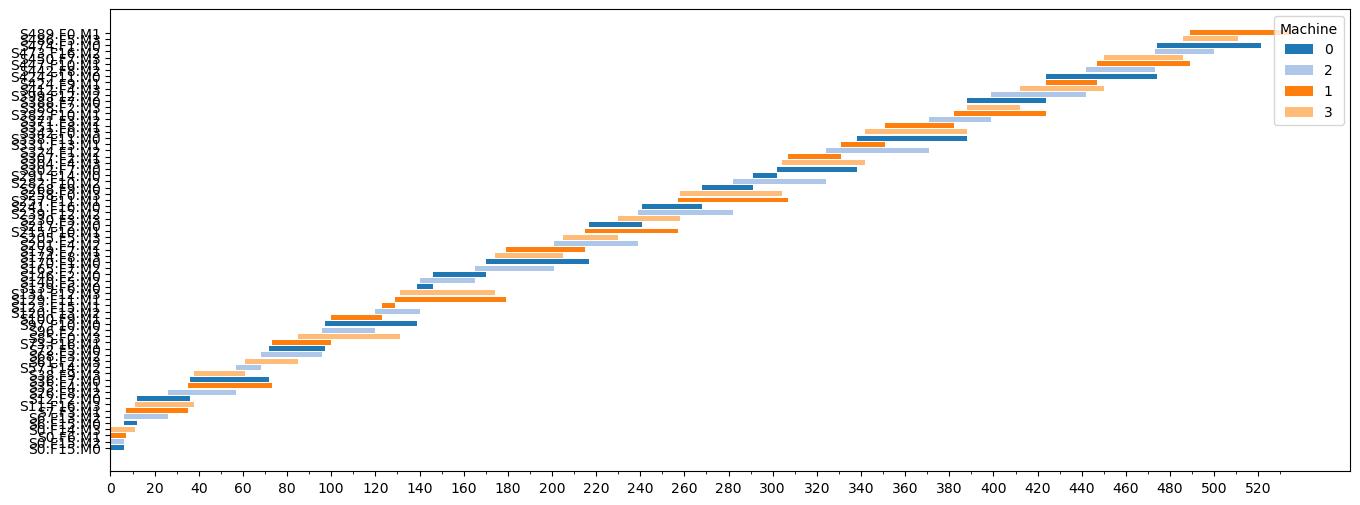

In [18]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch


plt.figure(figsize=(32, 20), dpi=80)

c_dict = {k: v for k, v in zip(schedule.m.unique(), plt.cm.tab20.colors)}
fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(schedule.index, schedule.C - schedule.S, left=schedule.S, color=schedule.m.map(c_dict))
##### LEGENDS #####
legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
plt.legend(handles=legend_elements, title="Machine", loc="upper right")
##### TICKS #####
xticks = np.arange(0, schedule.C.max()+1, 20)
xticks_labels = pd.date_range(schedule.S.min(), end=schedule.C.max())
xticks_minor = np.arange(0, schedule.C.max()+1, 10)
ax.set_xticks(xticks)
ax.set_xticks(xticks_minor, minor=True)
plt.show()

# Dekompositionsheuristik

In [21]:
from itertools import permutations

LAMBDA = 5
ALPHA = 2
ITER_MAX = 15

def update_machine_schedule(machine_schedule: pd.DataFrame) -> pd.DataFrame:
    modified_schedule = machine_schedule.copy()
    S, C = (np.sort(machine_schedule[col].unique()) for col in ["S", "C"])
    indices = machine_schedule.index.unique()
    for i, index in enumerate(indices):
        modified_schedule.loc[index, ["S", "C"]] = S[i], C[i]
        modified_schedule.sort_values(by=["S"], inplace=True)
    return modified_schedule


# get by machine schedules
machine_schedules = [m for _, m in schedule.groupby("m")]
for ms in machine_schedules:
    print(f"Machine {ms.m[0]}:")
    for i in range(ITER_MAX):
        # list of remaining batch ids (starting order) and list of final batch ids (order after applying the heuristic)
        old_order = list(ms.index.unique())
        new_order = list()
        # iterate over segments until all batches are rescheduled
        while len(old_order) > 0:
            # current segment data
            segment_twt = None
            segment_ids = old_order[:min(LAMBDA, len(old_order))]
            segment = schedule.loc[segment_ids]
            # iterate over all permutations of the segment
            for permutation in permutations(segment_ids):
                # get a schedule with the new order of the segment and update the S and C values
                segment = update_machine_schedule(schedule.loc[list(permutation)])
                # calculate the segment TWT
                temp_twt = calculate_twt(segment.loc[list(permutation)])
                # update the best TWT and the best permutation
                if segment_twt is None or temp_twt < segment_twt:
                    segment_twt = temp_twt
                    segment_ids = list(permutation)
            # add the best permutation to the final order and remove it from the remaining batches
            for id in segment_ids[:min(ALPHA, len(segment_ids))]:
                new_order.append(id)
                old_order.remove(id)
        # update the schedule with the new order
        before = calculate_twt(ms)
        ms = update_machine_schedule(schedule.loc[new_order])
        after = calculate_twt(ms)
        print(f"Iteration {i} TWT: {before} -> {calculate_twt(ms)}")
        schedul
        if after >= before:
            break


Machine 0:
Iteration 0 TWT: 17928.0 -> 13683.0
Machine 1:
Iteration 0 TWT: 19030.0 -> 14255.0
Machine 2:
Iteration 0 TWT: 16857.0 -> 15825.0
Machine 3:
Iteration 0 TWT: 17528.0 -> 16151.0


## VNS-Verfahren

In [20]:
# helper function for choosing a random machine queue
def random_machine_queues() -> Tuple[List[Batch], List[Batch]]:
    a = random.choice(machine_queues)
    b = random.choice([q for q in machine_queues if q != a])
    return a, b

# helper function for choosing a random machine queue and an index 
def random_machine_queues_and_indices() -> Tuple[Tuple[List[Batch], int], Tuple[List[Batch], int]]:
    a, b = random_machine_queues()
    index_a, index_b = random.randint(0, len(a) - 1), random.randint(0, len(b) - 1)
    return (a, index_a), (b, index_b)

# helper function for updating the completion times of batches
def update_completion_times(queue: List[Batch], index: int):
    for i in range(index, len(queue)):
        # add the processing time of the batch to the completion time of the previous batch
        queue[i].C = queue[i].p
        if i > 0:
            queue[i].C += queue[i - 1].C
        # apply the completion time to the jobs of the batch
        queue[i].apply_C_to_jobs()

# Neighborhood 1: Swap two batches
def swap_batch(r: int):
    for i in range(r):
        # get two random machine queues and their indices
        (a, index_a), (b, index_b) = random_machine_queues_and_indices()
        # swap the batches at the indices
        a[index_a], b[index_b] = b[index_b], a[index_a]
        # update the completion times of the batches
        update_completion_times(a, index_a)
        update_completion_times(b, index_b)

# Neighborhood 2: Swap two batch sequences
def swap_seq(r: int):
    # get two random machine queues and their indices
    (a, index_a), (b, index_b) = random_machine_queues_and_indices()
    # swap the batch sequences of length r at the indices
    a[index_a:index_a+r], b[index_b:index_b+r] = b[index_b:index_b+r], a[index_a:index_a+r]
    # update the completion times of the batches
    update_completion_times(a, index_a)
    update_completion_times(b, index_b)

# Neighborhood 3: Move a batch
def move_batch(r):
    for i in range(r):
        # get two random machine queues and their indices
        (a, index_a), (b, index_b) = random_machine_queues_and_indices()
        # remove the batch from the first queue and insert it into the second queue
        b.insert(index_b, a.pop(index_a))
        # update the completion times of the batches
        update_completion_times(a, index_a)
        update_completion_times(b, index_b)

# Neighborhood 4: Move a batch sequence
def move_seq(r):
    # get two random machine queues and their indices
    (a, index_a), (b, index_b) = random_machine_queues_and_indices()
    # remove the batch sequence of length r from the first queue and insert it into the second queue
    for i in range(r):
        if len(a) <= index_a:
            break
        b.insert(index_b+r, a.pop(index_a))
    # update the completion times of the batches
    update_completion_times(a, index_a)
    update_completion_times(b, index_b)

NameError: name 'Tuple' is not defined

In [ ]:
import itertools


def balance_workload(machine_queues: List[List[Batch]] = machine_queues):
    while True:
        # get max C of all queues
        C_q_max = [queue[-1].C for queue in machine_queues]
        # get the index r of the queue with max C
        r = C_q_max.index(max(C_q_max))
        # get the index r of the queue with min C
        s = C_q_max.index(min(C_q_max))
        # save total C max
        C_max = C_q_max[r]
        # move last batch from queue r to queue s if C max decreases
        temp_machine_queues = copy.deepcopy(machine_queues)
        temp_machine_queues[s].append(temp_machine_queues[r].pop())
        update_completion_times(temp_machine_queues[r], len(temp_machine_queues[r]) - 1)
        update_completion_times(temp_machine_queues[s], len(temp_machine_queues[s]) - 1)
        if max([queue[-1].C for queue in temp_machine_queues]) < C_max:
            print("here")
            machine_queues = temp_machine_queues
        else:
            break


# TODO     
def swap(machine_queues: List[List[Batch]] = machine_queues):
    S_f = set()
    for index, p in enumerate(p_f):
        B_f_without_S_f = set([batch for queue in machine_queues for batch in queue]) - S_f
        b = min([batch for batch in B_f_without_S_f])
        for job in [batch.jobs for batch in B_f_without_S_f]
        
        
swap()

: 

: 